# Reddit Climate Change
Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

## Project Understanding
- Research question / project goal --> will be set after first data investigation and group discussion
- Legal limitations? Privacy limitations?

In [27]:
# Preparing the environment
%pip install pandas
%pip install wordcloud
%pip install nltk
%pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing data
raw_comments = pd.read_csv('/Users/anja/Documents/DataDataScienceClass/the-reddit-climate-change-dataset-comments.csv')
raw_posts = pd.read_csv('/Users/anja/Documents/DataDataScienceClass/the-reddit-climate-change-dataset-posts.csv')

## Data Unterstanding
- What data do we have? 
- What do we need to take care of in data preparation?

### Comments Dataset

In [6]:
# Checking 'comments' dataset structure
raw_comments.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,imlddn9,2qh3l,news,False,1661990368,https://old.reddit.com/r/news/comments/x2cszk/...,Yeah but what the above commenter is saying is...,0.5719,2
1,comment,imldbeh,2qn7b,ohio,False,1661990340,https://old.reddit.com/r/Ohio/comments/x2awnp/...,Any comparison of efficiency between solar and...,-0.9877,2
2,comment,imldado,2qhma,newzealand,False,1661990327,https://old.reddit.com/r/newzealand/comments/x...,I'm honestly waiting for climate change and th...,-0.1143,1
3,comment,imld6cb,2qi09,sacramento,False,1661990278,https://old.reddit.com/r/Sacramento/comments/x...,Not just Sacramento. It's actually happening a...,0.0000,4
4,comment,imld0kj,2qh1i,askreddit,False,1661990206,https://old.reddit.com/r/AskReddit/comments/x2...,I think climate change tends to get some peopl...,0.6634,1


In [36]:
# Checking datatypes of 'comments' dataset
raw_comments.dtypes

type                              object
id                                object
subreddit.id                      object
subreddit.name                    object
subreddit.nsfw                      bool
created_utc                        int64
permalink                         object
body                              object
sentiment                        float64
score                              int64
converted_created    datetime64[ns, UTC]
created_converted    datetime64[ns, UTC]
created_date                      object
dtype: object

In [40]:
# Convert comments timestamps and create a date column
raw_comments['created_converted'] = pd.to_datetime(raw_comments['created_utc'], utc=True)
raw_comments['created_date'] = pd.to_datetime(raw_comments['created_converted']).dt.normalize()

#### To Dos and Open Questions for Comments Dataset
- Convert timestamp --> when converted there are posts from 1970, erroneos data? or something wrong with datetime conversion?
- There is already a sentiment score, how is it created and what does it mean? what is the scale?
- What is the score?
- Difference beweeen subreddit and reddit? why is there only a subreddit named in the dataset?
- How much data is there per time unit / is the data equally distributed over time?

### Posts Dataset

In [5]:
# Checking 'posts' dataset structure
raw_posts.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,x2smmw,2vh0v,democraticsocialism,False,1661990237,https://old.reddit.com/r/DemocraticSocialism/c...,twitter.com,https://twitter.com/SusanofTexas/status/156480...,NaN,“Cities without water” is our future. The lead...,15
1,post,x2slxy,2w844,nostupidquestions,False,1661990182,https://old.reddit.com/r/NoStupidQuestions/com...,self.nostupidquestions,NaN,Ok so I was having a conversation with my neig...,Sharks and climate change,2
2,post,x2slk5,6wzx9b,eduwriters,False,1661990150,https://old.reddit.com/r/EduWriters/comments/x...,eduwriters.pro,https://eduwriters.pro/?cid=2860/?utm_source=r...,NaN,How to start a climate change essay,1
3,post,x2sbz6,46adh7,alternatitvereality,False,1661989389,https://old.reddit.com/r/AlternatitveReality/c...,i.imgur.com,https://i.imgur.com/wJbchkQ.jpg,NaN,Ever notice that when it’s hot a few days in J...,1
4,post,x2sa2a,2qh1i,askreddit,False,1661989240,https://old.reddit.com/r/AskReddit/comments/x2...,self.askreddit,NaN,[deleted],How would you react if the next American presi...,1


In [35]:
# Checking datatypes of 'posts' dataset
raw_posts.dtypes

type                              object
id                                object
subreddit.id                      object
subreddit.name                    object
subreddit.nsfw                      bool
created_utc                        int64
permalink                         object
domain                            object
url                               object
selftext                          object
title                             object
score                              int64
created_converted    datetime64[ns, UTC]
dtype: object

In [39]:
# Convert post timestamps and create a date column
raw_posts['created_converted'] = pd.to_datetime(raw_posts['created_utc'], utc=True)
raw_posts['created_date'] = pd.to_datetime(raw_posts['created_converted']).dt.normalize()

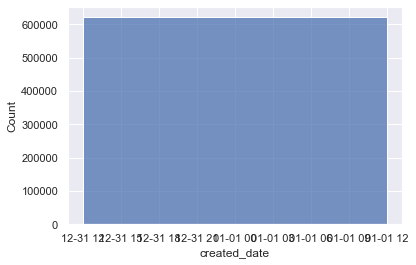

0        1970-01-01 00:00:00+00:00
1        1970-01-01 00:00:00+00:00
2        1970-01-01 00:00:00+00:00
3        1970-01-01 00:00:00+00:00
4        1970-01-01 00:00:00+00:00
                    ...           
620903   1970-01-01 00:00:00+00:00
620904   1970-01-01 00:00:00+00:00
620905   1970-01-01 00:00:00+00:00
620906   1970-01-01 00:00:00+00:00
620907   1970-01-01 00:00:00+00:00
Name: created_date, Length: 620908, dtype: datetime64[ns, UTC]

In [42]:
# Distribution of datapoints

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
sns

sns.histplot(data=raw_posts, x="created_date")
plt.show()

raw_posts['created_date']

#### To Dos and Open Questions for Posts Dataset
- What types are there in the post dataset? Only posts?
- How does reddit work?
- Subreddits are comments underneath a main post? 
- Convert timestamp and check for what timeframe there are posts and comments --> when converted there are posts from 1970, erroneos data? or something wrong with datetime conversion?
- Who is giving the subreddit name? the author of the post?
- Nsfw = "not safe for work"; bad content?
- What domains are there? and what does it mean if there is a domain such as twitter? posts get retweeted / reused from other platforms?
- What is the score? 
- How much data is there per time unit / is the data equally distributed over time?

## Data Preparation

## Modeling

## Evaluation

## Deployment
Since this project is only for training purpose there probably won't be a live deployment